# Approche non suppervisée 

#### Contexte : 
On souhaite catégoriser les questions issues de Stackoverflow.

Nous avons précédemment effectué les étapes de pré-traitement (nettoyage des textes, tokenisation, suppression de stop words et lemmatisation)

Dans ce notebook, nous allons tester une approche non supervisée pour prédire les tags.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# from nltk.corpus import stopwords
# from nltk.tokenize import RegexpTokenizer
# from nltk.stem import WordNetLemmatizer


In [2]:
data = pd.read_csv("data_clean.csv")

In [3]:
data.head(5)

,Title,Body,Tags,Score,ViewCount,AnswerCount,CreationDate,Corpus,Extracted_code,New_Tags,Nb_Tags,Title_tokens,Body_tokens,Corpus_tokens,Body_tokens_str,Title_tokens_str,Corpus_tokens_str
0,is it normal to have two different dependent a...,system io filesystem primitives b f f f d...,"['c#', 'asp.net', 'model-view-controller', '.n...",5,419,2,2020-02-19 07:57:36,is it normal to have two different dependent a...,lt dependentassembly gt n lt a...,"['c#', 'asp.net']",2,"['normal', 'two', 'different', 'dependent', 'a...","['system', 'io', 'filesystem', 'primitive', 'b...","['normal', 'two', 'different', 'dependent', 'a...",system io filesystem primitive b f f f system ...,normal two different dependent assembly public...,normal two different dependent assembly public...
1,keycloak authentication problems when using do...,so i have a spring boot application i also us...,"['java', 'spring', 'spring-boot', 'docker', 'k...",3,4805,1,2020-01-07 12:09:05,keycloak authentication problems when using do...,keycloak n image jboss keycloak n ...,"['java', 'spring', 'spring-boot', 'docker']",4,"['keycloak', 'authentication', 'problem', 'usi...","['spring', 'boot', 'application', 'also', 'use...","['keycloak', 'authentication', 'problem', 'usi...",spring boot application also use swagger testi...,keycloak authentication problem using docker j...,keycloak authentication problem using docker j...
2,azure functions http trigger how to return e...,i m new to azure functions wished to know how...,"['python-3.x', 'azure', 'azure-functions', 'az...",2,2533,1,2020-01-07 12:10:13,azure functions http trigger how to return e...,,"['python-3.x', 'azure']",2,"['azure', 'function', 'http', 'trigger', 'retu...","['new', 'azure', 'function', 'wished', 'know',...","['azure', 'function', 'http', 'trigger', 'retu...",new azure function wished know return exceptio...,azure function http trigger return exception p...,azure function http trigger return exception p...
3,why doesn t the pod dependency manager detect ...,so this question is a follow up to my previo...,"['javascript', 'reactjs', 'react-native', 'mod...",6,2483,2,2020-01-13 22:20:14,why doesn t the pod dependency manager detect ...,yarn add react native community masked view...,"['javascript', 'reactjs', 'react-native']",3,"['pod', 'dependency', 'manager', 'detect', 'ne...","['question', 'follow', 'previous', 'question',...","['pod', 'dependency', 'manager', 'detect', 'ne...",question follow previous question different ap...,pod dependency manager detect necessary module...,pod dependency manager detect necessary module...
4,how to add an unique constraint ignoring spec...,how to add an unique constraint ignoring spec...,"['sql', 'regex', 'postgresql', 'unique-constra...",2,1396,2,2020-01-13 22:23:55,how to add an unique constraint ignoring spec...,create table my table n sometextcolumn c...,"['sql', 'regex', 'postgresql']",3,"['add', 'unique', 'constraint', 'ignoring', 's...","['add', 'unique', 'constraint', 'ignoring', 's...","['add', 'unique', 'constraint', 'ignoring', 's...",add unique constraint ignoring special charact...,add unique constraint ignoring special charact...,add unique constraint ignoring special charact...


# LDA (Latent Dirichlet allocation)

Nous testons la LDA avec deux techniques d'embeddings : 
   - Bag of Words
   - TF-IDF

In [5]:
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import warnings
warnings.filterwarnings("ignore")

In [6]:
data.dropna(inplace=True)

In [7]:
data_corpus = data["Corpus_tokens"]

In [12]:
bigram = gensim.models.Phrases(data_corpus, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_corpus], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

### 1- Bag of Words :

In [8]:
data_corpus = [d.split() for d in data_corpus]

In [9]:
# Création du dictionnaire BoW
dict_bow = corpora.Dictionary(data_corpus)

# Création du corpus BoW
corpus_bow = [dict_bow.doc2bow(text) for text in data_corpus]

In [29]:
# from gensim.models.coherencemodel import CoherenceModel
import time
coherence_test = []
for k in np.arange(1,50,5):
    
    start_time = time.time()
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_bow,
                                                        id2word=dict_bow,
                                                        num_topics=k,
                                                        random_state=21,
                                                        per_word_topics=True,
                                                        workers=6)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_corpus,
                                         dictionary=dict_bow,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    k_time = end_time - start_time
    coherence_test.append((k, coherence_lda, k_time))
     

In [30]:
coherence_test

[(1, 0.4793317268782341, 14.592422723770142),
 (6, 0.44003668077220565, 39.17605972290039),
 (11, 0.4377077041928907, 49.205384969711304),
 (16, 0.4634062597751841, 52.85546064376831),
 (21, 0.4518717334082166, 62.16807460784912),
 (26, 0.44745701645762603, 69.21122813224792),
 (31, 0.443863022874258, 78.7045066356659),
 (36, 0.43677142147629827, 90.4726996421814),
 (41, 0.4516344981981758, 103.90415406227112),
 (46, 0.44617001121837063, 119.24878191947937)]

In [39]:
# from gensim.models.coherencemodel import CoherenceModel
import time
coherence_test = []
for k in np.arange(2,21):
    
    start_time = time.time()
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_bow,
                                                        id2word=dict_bow,
                                                        num_topics=k,
                                                        random_state=21,
                                                        per_word_topics=True,
                                                        workers=6)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_corpus,
                                         dictionary=dict_bow,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    k_time = end_time - start_time
    coherence_test.append((k, coherence_lda, k_time))
     

In [36]:
# coherence_test k = (10,11,...,20) seed = 21

[(10, 0.44555412319991194, 47.644097566604614),
 (11, 0.4428624118401286, 58.185006618499756),
 (12, 0.437069475160008, 57.09574317932129),
 (13, 0.4495371916376488, 59.42861223220825),
 (14, 0.46105004139486855, 67.13515496253967),
 (15, 0.44575670491229535, 70.3545413017273),
 (16, 0.46784650262639627, 74.09413552284241),
 (17, 0.47446953004836273, 70.23435568809509),
 (18, 0.4557204235614221, 71.51132392883301),
 (19, 0.44794887231825425, 72.48006010055542),
 (20, 0.4417673036451994, 76.23230481147766)]

In [12]:
# coherence_test - version N°1 k = (1, 50, 5) seed = 21

[(1, 0.4793317268782341, 17.083362102508545),
 (6, 0.4369507269157551, 47.31581449508667),
 (11, 0.4378721453744742, 57.996787786483765),
 (16, 0.4713163891552052, 66.56018161773682),
 (21, 0.4368952933336646, 71.76787853240967),
 (26, 0.44745701645762603, 81.70002245903015),
 (31, 0.44287008389440535, 88.39991331100464),
 (36, 0.4419045036883685, 98.74775743484497),
 (41, 0.4507032260607738, 114.91452217102051),
 (46, 0.4476758987836174, 126.71521472930908)]

In [40]:
# Create dataframe of results

coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_test

,k,coherence,time
0,2,0.444964,38.185958
1,3,0.411935,43.026275
2,4,0.424549,42.389061
3,5,0.424842,49.526255
4,6,0.431572,49.989969
5,7,0.427653,53.292013
6,8,0.444361,53.454650
7,9,0.448166,58.547485
8,10,0.445554,57.940528
9,11,0.438782,60.296160


In [41]:
# Select best number of topics
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]

In [42]:
best_nb_topics

17

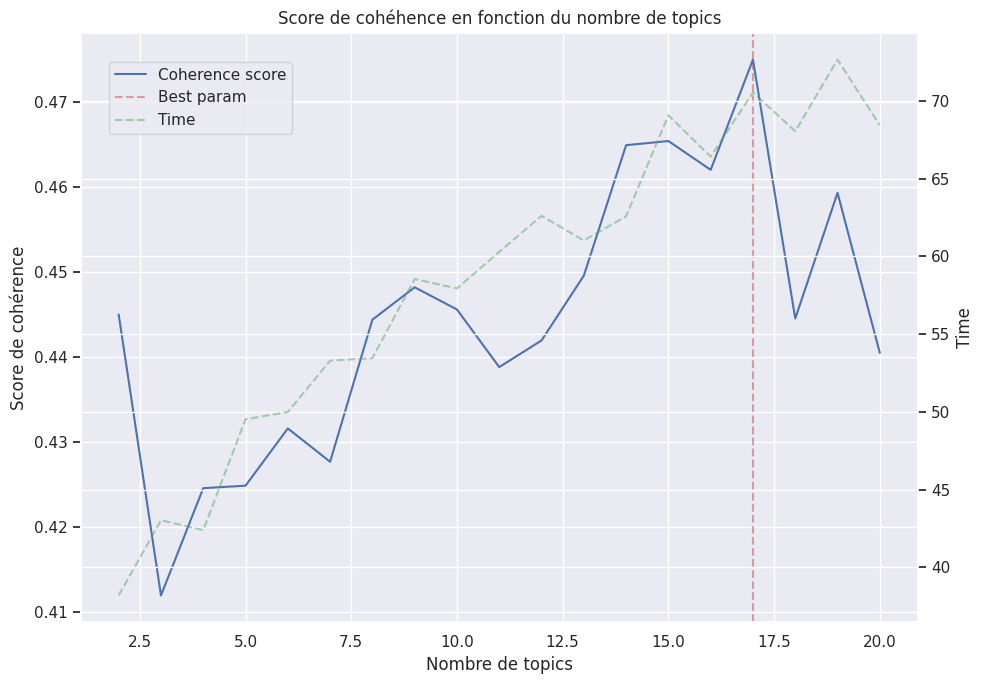

In [72]:
# Plot results
sns.set()
fig, ax1 = plt.subplots(figsize=(10,7))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]
ax1.set_axis_on
ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=0.5,
            linestyle='--', label='Best param')
ax1.set_xlabel("Nombre de topics")
ax1.set_ylabel("Score de cohérence")
ax1.set_title("Score de cohéhence en fonction du nombre de topics")
ax2 = ax1.twinx()
ax2.plot(x, y2, color='g', alpha=0.5,
         label="Time", linestyle='--')
ax2.set_ylabel("Time")

legend = fig.legend(#loc="upper left"),
                    bbox_to_anchor=(0.3, 0.9))

fig.tight_layout()
plt.show()

In [ ]:
# lda = LatentDirichletAllocation(random_state=42,
#                                 batch_size=400)

In [74]:
from gensim.models import LdaModel
from sklearn.model_selection import GridSearchCV


In [79]:
# Définir les paramètres à rechercher
params = {'num_topics': [17],  # le nombre de topics optimal choisi
         'passes': [10, 15, 20],
         'decay': [0.5, 0.75]   
        }

# Créez le modèle LDA
lda = LdaModel(id2word=dict_bow, random_state=21)

# Utilisez GridSearchCV
grid_search = GridSearchCV(lda, 
                           params, 
                           cv=5,
                          return_train_score=True
                          )
grid_search.fit(corpus_bow)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got <gensim.models.ldamodel.LdaModel object at 0x7f6e341655b0> instead.

In [86]:
from sklearn.decomposition import LatentDirichletAllocation
from gensim.matutils import corpus2csc


# Convertir le corpus BoW en une matrice creuse
corpus_matrix = corpus2csc(corpus_bow)

# Définir les paramètres à rechercher
params = {'n_components': [17],  # le nombre de topics optimal choisi
          'learning_decay': [0.5, 0.7, 0.9],
          'learning_method' : ['batch', 'online']
         }

# Init the Model 
lda = LatentDirichletAllocation(random_state=21)

# Init Grid Search Class
grid_search = GridSearchCV(lda,
                           param_grid=params,
                           cv=5,
                           return_train_score=True)

# Fit Grid Search
grid_search.fit(corpus_matrix)

GridSearchCV(cv=5, estimator=LatentDirichletAllocation(random_state=21),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [17]},
             return_train_score=True)

In [89]:
best_lda_model =grid_search.best_estimator_

print("Best params: ", grid_search.best_params_)

Best params:  {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 17}


In [92]:
# print('\nPerplexity: ', best_lda_model.log_perplexity(corpus_matrix))
print("Best Log Likelihood Score: ", grid_search.best_score_)
     

Best Log Likelihood Score:  -21069530.164807744


In [94]:
grid_search.cv_results_

{'mean_fit_time': array([337.27742462, 680.20067205, 317.242659  , 614.36981902,
        308.07773576, 718.98213592]),
 'std_fit_time': array([134.62133673,  58.20622087, 119.41383474,  53.16173835,
        116.05514731, 108.10442614]),
 'mean_score_time': array([5.07605805, 4.39465103, 4.80189099, 4.03752213, 4.83769913,
        4.21827826]),
 'std_score_time': array([3.4812843 , 4.21033278, 3.35001969, 3.51706449, 3.424392  ,
        2.84773649]),
 'param_learning_decay': masked_array(data=[0.5, 0.5, 0.7, 0.7, 0.9, 0.9],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_learning_method': masked_array(data=['batch', 'online', 'batch', 'online', 'batch',
                    'online'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_components': masked_array(data=[17, 17, 17, 17, 17, 17],
              mask=[False, False, False, False, Fal

In [163]:
lda_model_gensim = gensim.models.ldamodel.LdaModel(corpus = corpus_bow,
                                                   id2word = dict_bow,
                                                   num_topics = 17,
                                                   decay=0.7,
                                                   random_state = 21
#                                                    update_every = 1,
#                                                    chunksize = 100,
#                                                    passes = 10,
#                                                    alpha  = "auto"
                                                  )

### Analyse des topics :

#### Visualisation des topics avec la technique nmds : Non-metric Multidimensional Scaling

In [180]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model_gensim, 
                              corpus_bow, 
                              dict_bow, 
                              mds = "nmds",
#                               R=10
                             )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.017507  0.169114       1        1  16.616854
6      0.197088  0.109067       2        1   9.282231
5     -0.143178  0.064087       3        1   8.783808
9     -0.139810  0.014274       4        1   8.299937
16     0.171405  0.005033       5        1   6.956389
1      0.138552 -0.139196       6        1   6.593731
14    -0.132824  0.006835       7        1   6.474094
3      0.072615  0.111291       8        1   6.282711
13    -0.181871 -0.010947       9        1   5.167239
10     0.002645  0.020285      10        1   4.965327
7     -0.088548 -0.026264      11        1   4.258644
11    -0.039279  0.045951      12        1   3.512658
2     -0.003248  0.036814      13        1   3.114279
4      0.178042 -0.002741      14        1   2.943827
12     0.009639 -0.377252      15        1   2.512617
8      0.039232 -0.021416      16        1   2.415258
15    -0.097969 -0.004935      17        1   1.820396, topic_info=               Term          Freq         Total Category  logprob  loglift
229         'file',  47601.000000  47601.000000  Default  30.0000  30.0000
32           'app',  36855.000000  36855.000000  Default  29.0000  29.0000
604            'j',  25468.000000  25468.000000  Default  28.0000  28.0000
314        'class',  32632.000000  32632.000000  Default  27.0000  27.0000
453            'x',  20412.000000  20412.000000  Default  26.0000  26.0000
..              ...           ...           ...      ...      ...      ...
77         'using',    844.614651  61063.406499  Topic17  -5.0058  -0.2747
419          'see',    620.639150  14004.694906  Topic17  -5.3139   0.8897
834        'tried',    605.332792  27702.423792  Topic17  -5.3389   0.1826
187      'project',    594.714712  20917.484645  Topic17  -5.3566   0.4459
33   'application',    546.381046  15617.087775  Topic17  -5.4414   0.6533

[1453 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
3020       3  0.988056         'aarch',
2859       8  0.005540            'ac',
2859      17  0.991715            'ac',
494        1  0.100521        'access',
494        2  0.002170        'access',
...      ...       ...              ...
6269       9  0.987345         ['unit',
11890      6  0.006526       ['visual',
11890     17  0.991907       ['visual',
8087       5  0.989136  ['woocommerce',
8087       6  0.006382  ['woocommerce',

[8360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 10, 17, 2, 15, 4, 14, 11, 8, 12, 3, 5, 13, 9, 16])

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

Nous constatons que certains topics sont proches avec des mots similaires et parfois communs

#### Visualisation des topics avec la tsne :

In [179]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_gensim, 
                              corpus_bow, 
                              dict_bow, 
                              mds = "tsne",
#                               R=10
                             )
vis

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0      107.761192  -21.692513       1        1  16.615657
6      160.800171   45.487759       2        1   9.283019
5       79.318565 -169.675613       3        1   8.784143
9      -25.252134   57.306976       4        1   8.300642
16    -156.892090  -60.986916       5        1   6.955584
1       45.673973   26.012701       6        1   6.594620
14      -5.377260  -32.554844       7        1   6.473151
3     -104.471924 -158.208694       8        1   6.283813
13     153.200226  -93.477722       9        1   5.166765
10      52.081833  -84.293228      10        1   4.964422
7        3.913833  140.238754      11        1   4.259264
11     -10.710640 -146.677383      12        1   3.513298
2      -83.666985    2.573399      13        1   3.114966
4      -93.123154  112.951523      14        1   2.943648
12      85.003128  100.228188      15        1   2.512659
8      -67.002548  -79.812462      16        1   2.414655
15    -160.241806   41.062019      17        1   1.819694, topic_info=               Term          Freq         Total Category  logprob  loglift
229         'file',  47605.000000  47605.000000  Default  30.0000  30.0000
32           'app',  36853.000000  36853.000000  Default  29.0000  29.0000
604            'j',  25465.000000  25465.000000  Default  28.0000  28.0000
314        'class',  32634.000000  32634.000000  Default  27.0000  27.0000
453            'x',  20413.000000  20413.000000  Default  26.0000  26.0000
..              ...           ...           ...      ...      ...      ...
77         'using',    844.289002  61063.571888  Topic17  -5.0058  -0.2747
419          'see',    620.399857  14004.474649  Topic17  -5.3139   0.8897
834        'tried',    605.099401  27702.434446  Topic17  -5.3389   0.1826
187      'project',    594.485414  20917.334943  Topic17  -5.3566   0.4459
33   'application',    546.170384  15617.199251  Topic17  -5.4414   0.6533

[1453 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
3020       3  0.988019         'aarch',
2859       8  0.005542            'ac',
2859      17  0.992094            'ac',
494        1  0.100518        'access',
494        2  0.002169        'access',
...      ...       ...              ...
6269       9  0.987434         ['unit',
11890      6  0.006528       ['visual',
11890     17  0.992286       ['visual',
8087       5  0.989249  ['woocommerce',
8087       6  0.006382  ['woocommerce',

[8360 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 7, 6, 10, 17, 2, 15, 4, 14, 11, 8, 12, 3, 5, 13, 9, 16])

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

Avec la tsne, les cerles sont disjoints, ce qui suggèrent que les sujets sont indépendants les uns des autres.

### Exploration des termes clés :

In [182]:
# Obtenir les termes clés pour chaque topic
topics = lda_model_gensim.print_topics(num_topics=17, num_words=5)

# Affichage des termes clés
for topic in topics:
    print(topic)
    

(0, '0.018*"\'code\'," + 0.014*"\'using\'," + 0.013*"\'like\'," + 0.012*"\'would\'," + 0.010*"\'use\',"')
(1, '0.037*"\'image\'," + 0.020*"\'div\'," + 0.020*"\'color\'," + 0.017*"\'text\'," + 0.016*"\'px\',"')
(2, '0.026*"\'message\'," + 0.024*"\'user\'," + 0.019*"\'video\'," + 0.018*"\'page\'," + 0.016*"\'view\',"')
(3, '0.027*"\'type\'," + 0.023*"\'object\'," + 0.022*"\'class\'," + 0.018*"\'string\'," + 0.016*"\'value\',"')
(4, '0.042*"\'x\'," + 0.030*"\'self\'," + 0.030*"\'thread\'," + 0.019*"\'size\'," + 0.017*"\'memory\',"')
(5, '0.018*"\'user\'," + 0.018*"\'docker\'," + 0.013*"\'using\'," + 0.012*"\'http\'," + 0.012*"\'service\',"')
(6, '0.019*"\'value\'," + 0.019*"\'column\'," + 0.015*"\'model\'," + 0.013*"\'dataframe\'," + 0.013*"\'data\',"')
(7, '0.032*"\'java\'," + 0.026*"\'spring\'," + 0.017*"\'public\'," + 0.016*"\'class\'," + 0.016*"\'boot\',"')
(8, '0.039*"\'event\'," + 0.035*"\'c\'," + 0.024*"\'view\'," + 0.013*"\'layout\'," + 0.012*"\'h\',"')
(9, '0.035*"\'error\'," + 0

### Analyse des distribution des topics : 

In [187]:
# Obtenir les distributions de topics pour chaque document
# doc_topics = lda_model_gensim.transform(corpus_matrix)
doc_topics = [lda_model_gensim.get_document_topics(doc) for doc in corpus_bow]

# Affichage des distributions de topics pour quelques documents 
for i in range(5): #par exemple, les 5 premiers
    print(f"Document {i + 1}: {doc_topics[i]}")

Document 1: [(5, 0.072335206), (6, 0.48091993), (7, 0.07831367), (9, 0.30191612), (13, 0.05114709)]
Document 2: [(3, 0.049485963), (5, 0.62471795), (7, 0.12720057), (13, 0.18937966)]
Document 3: [(4, 0.1665158), (5, 0.13783295), (7, 0.2810921), (8, 0.038791478), (9, 0.027364448), (14, 0.31171006), (16, 0.032764137)]
Document 4: [(0, 0.21482925), (9, 0.19930997), (10, 0.2402075), (13, 0.3388787)]
Document 5: [(6, 0.15359905), (16, 0.8179121)]


### Etude de cas : 

In [192]:
max(doc_topics[0])

(13, 0.05114709)

In [202]:
max(doc_topics[0:])

[(16, 0.99258775)]

In [239]:
# On choisit un sujet spécifique 
selected_topic = 1 #par exemple sujet 0

# Obtenir les indices des documents ayant une forte probabilité pour ce sujet
# relevant_docs_indices = [i for i, doc_topic in enumerate(doc_topics) if doc_topic.argmax() == selected_topic]
relevant_docs_indices = [i for i, doc_topic in enumerate(doc_topics) if max(doc_topic, key=lambda x: x[1])[0] == selected_topic]
print(f"Topic : {selected_topic}")
# Afficher les tags des questions de ce topic
for doc_index in relevant_docs_indices[:5]:
    print(f"Document {doc_index + 1} : {data['Tags'].iloc[doc_index]}")


Topic : 1
Document 19 : ['python', 'python-3.x', 'list', 'opencv', 'python-imaging-library']
Document 23 : ['flutter', 'dart', 'background-image', 'assets', 'cardview']
Document 52 : ['html', 'css', 'templates', 'rollup', 'rollupjs']
Document 63 : ['ios', 'swift', 'swiftui', 'scrollview', 'geometryreader']
Document 132 : ['html', 'css', 'progress-bar', 'linear-gradients', 'repeating-linear-gradient']


In [229]:
def print_topics_tags(selected_topic, nb_doc):
    
    relevant_docs_indices = [i for i, doc_topic in enumerate(doc_topics) if max(doc_topic, key=lambda x: x[1])[0] == selected_topic-1]
    nb_topic = lda_model_gensim.num_topics
    if selected_topic in range(1,nb_topic+1):
        print(f"Topic : {selected_topic}")
        # Afficher les tags des questions de ce topic
        for doc_index in relevant_docs_indices[:nb_doc]:
            print(f"Document {doc_index + 1} : {data['Tags'].iloc[doc_index]}")

    else :
        print("Le numéro de topic n'est pas dans la liste des topics")
        

In [230]:
print_topics_tags(18, 5)
print_topics_tags(17,6)

Le numéro de topic n'est pas dans la liste des topics
Topic : 17
Document 5 : ['sql', 'regex', 'postgresql', 'unique-constraint', 'aws-serverless']
Document 33 : ['c#', '.net', 'winforms', 'graphics', 'listbox']
Document 37 : ['javascript', 'html', 'ads', 'shuffle', 'banner']
Document 41 : ['php', 'mysql', 'laravel', 'laravel-6', 'laravel-query-builder']
Document 68 : ['python-3.x', 'pandas', 'matplotlib', 'visualization', 'pygraphviz']
Document 117 : ['mysql', 'sql', 'database', 'database-performance', 'query-performance']


In [241]:
print(f'Perplexity: ', lda_model_gensim.log_perplexity(corpus_bow))


Perplexity:  -9.290830156681194


In [243]:
coherence_model_lda = CoherenceModel(model=lda_model_gensim, 
                                     texts=data_corpus,
                                     dictionary=dict_bow, 
                                     coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5290749491413295


### 2- Tf-IDF

In [251]:
from gensim import corpora, models

# Création du dictionnaire BoW
dict_tfidf = corpora.Dictionary(data_corpus)

# Création du corpus BoW
corpus_bow_2 = [dict_tfidf.doc2bow(text) for text in data_corpus]

# Création du modèle TF-IDF
tfidf = models.TfidfModel(corpus_bow_2)

# Transformation du corpus en TF-IDF
corpus_tfidf = tfidf[corpus_bow_2]


In [252]:
coherence_test = []
for k in np.arange(2,21):
    
    start_time = time.time()
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_tfidf,
                                                        id2word=dict_tfidf,
                                                        num_topics=k,
                                                        random_state=21,
                                                        per_word_topics=True,
                                                        workers=6)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_corpus,
                                         dictionary=dict_tfidf,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    k_time = end_time - start_time
    coherence_test.append((k, coherence_lda, k_time))
     

In [253]:
# Create dataframe of results

coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_test

,k,coherence,time
0,2,0.409842,36.445553
1,3,0.400615,38.172818
2,4,0.384573,47.808273
3,5,0.399413,49.429930
4,6,0.419259,49.806243
5,7,0.432137,54.633565
6,8,0.416778,45.310139
7,9,0.420451,53.646853
8,10,0.406683,56.800360
9,11,0.419484,57.242349


In [255]:
coherence_test = []
for k in np.arange(2,21):
    
    start_time = time.time()
    lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus_tfidf,
                                                        id2word=dict_tfidf,
                                                        num_topics=k,
                                                        random_state=21,
                                                        per_word_topics=True,
                                                        passes=20,
                                                        workers=7)
    coherence_model_lda = CoherenceModel(model=lda_model,
                                         texts=data_corpus,
                                         dictionary=dict_tfidf,
                                         coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    end_time = time.time()
    k_time = end_time - start_time
    coherence_test.append((k, coherence_lda, k_time))
    
coherence_test = pd.DataFrame(coherence_test,
                              columns=["k","coherence","time"])
coherence_test

,k,coherence,time
0,2,0.511074,454.769868
1,3,0.587652,404.045220
2,4,0.609319,397.782599
3,5,0.608253,441.784945
4,6,0.616855,476.882852
5,7,0.627770,465.235094
6,8,0.630536,467.366004
7,9,0.611307,444.145474
8,10,0.627803,447.771214
9,11,0.683087,441.069807


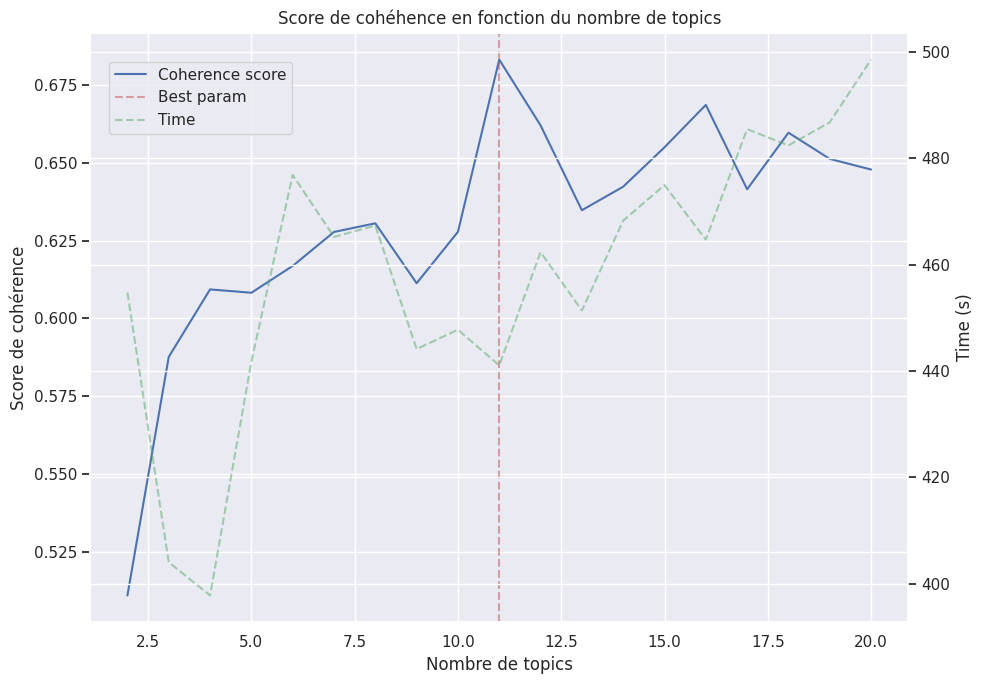

In [258]:
best_nb_topics = coherence_test.loc[coherence_test.coherence.argmax(),"k"]
# Plot results
sns.set()
fig, ax1 = plt.subplots(figsize=(10,7))
x = coherence_test["k"]
y1 = coherence_test["coherence"]
y2 = coherence_test["time"]
ax1.set_axis_on
ax1.plot(x, y1, label="Coherence score")
ax1.axvline(x=best_nb_topics, color='r', alpha=0.5,
            linestyle='--', label='Best param')
ax1.set_xlabel("Nombre de topics")
ax1.set_ylabel("Score de cohérence")
ax1.set_title("Score de cohéhence en fonction du nombre de topics")
ax2 = ax1.twinx()
ax2.plot(x, y2, color='g', alpha=0.5,
         label="Time", linestyle='--')
ax2.set_ylabel("Time (s)")

legend = fig.legend(#loc="upper left"),
                    bbox_to_anchor=(0.3, 0.9))

fig.tight_layout()
plt.show()

In [268]:
from sklearn.feature_extraction.text import TfidfVectorizer

#TfidfVectorizer(max_features=12000)
tfidf_vectorizer = TfidfVectorizer(max_features=12000)
vectorized_corpus = tfidf_vectorizer.fit_transform(data["Corpus_tokens"])

In [272]:
# from sklearn.decomposition import LatentDirichletAllocation
# from gensim.matutils import corpus2csc


# Convertir le corpus BoW en une matrice creuse
# corpus_matrix = corpus2csc(corpus_bow)

# Définir les paramètres à rechercher
params = {'n_components': [11],  # le nombre de topics optimal choisi
          'learning_decay': [0.5, 0.7, 0.9],
          'learning_method' : ['batch', 'online']
         }

# Init the Model 
lda = LatentDirichletAllocation(random_state=21, batch_size=400)

# Init Grid Search Class
grid_search = GridSearchCV(lda,
                           param_grid=params,
                           cv=5,
                           return_train_score=True)

# Fit Grid Search
grid_search.fit(vectorized_corpus)

GridSearchCV(cv=5,
             estimator=LatentDirichletAllocation(batch_size=400,
                                                 random_state=21),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'learning_method': ['batch', 'online'],
                         'n_components': [11]},
             return_train_score=True)

In [273]:
best_lda_model =grid_search.best_estimator_
print("Best params: ", grid_search.best_params_)

# print('\nPerplexity: ', best_lda_model.log_perplexity(corpus_matrix))
print("Best Log Likelihood Score: ", grid_search.best_score_)
     

Best params:  {'learning_decay': 0.9, 'learning_method': 'online', 'n_components': 11}
Best Log Likelihood Score:  -749846.6063684811


In [312]:
lda_model_2 = gensim.models.ldamodel.LdaModel(corpus = corpus_tfidf,
                                              id2word = dict_tfidf,
                                              num_topics = 11,
#                                               decay=0.9,
                                              random_state = 21
#                                               update_every = 1,
#                                               chunksize = 400,
#                                               passes = 20,
#                                               alpha  = "auto"
                                             )

In [313]:
print(f'Perplexity: ', lda_model_2.log_perplexity(corpus_tfidf))

coherence_model_lda = CoherenceModel(model=lda_model_2, 
                                     texts=data_corpus,
                                     corpus=corpus_tfidf,
                                     coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -12.194636176257267

Coherence Score:  0.5464995974443118


### ANalyse des topics :

In [316]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model_2, 
                              corpus_tfidf, 
                              dict_tfidf, 
                              mds = "PCoA",
#                               R=10
                             )
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.494387 -0.022963       1        1  67.737548
1     -0.015128  0.180966       2        1   5.465426
8      0.046515 -0.058452       3        1   4.535781
9      0.058700 -0.039402       4        1   4.347736
10     0.050667  0.003380       5        1   4.260151
6      0.060342 -0.011771       6        1   2.635915
3      0.059966 -0.013749       7        1   2.445485
4      0.058674 -0.010762       8        1   2.222251
5      0.058728 -0.010505       9        1   2.212223
7      0.058313 -0.009519      10        1   2.176749
2      0.057610 -0.007224      11        1   1.960734, topic_info=               Term        Freq       Total Category  logprob  loglift
1363         'div',  291.000000  291.000000  Default  30.0000  30.0000
223        'color',  275.000000  275.000000  Default  29.0000  29.0000
216         'text',  467.000000  467.000000  Default  28.0000  28.0000
2792      'button',  447.000000  447.000000  Default  27.0000  27.0000
314        'class',  670.000000  670.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
9777  'validating',    4.517758    5.124103  Topic11  -7.4658   3.8059
7122    'designer',    4.094991    4.701429  Topic11  -7.5640   3.7937
2701    'smoothly',    4.486819    5.179383  Topic11  -7.4727   3.7883
8803    'openpyxl',    3.889477    4.494964  Topic11  -7.6155   3.7872
1901   'undefined']    5.252149    6.104271  Topic11  -7.3152   3.7815

[515 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
10277      3  0.916745         'abc',
10277      7  0.026193         'abc',
10277      8  0.052385         'abc',
9835      11  0.915602       'admob',
4954      10  0.926755      'advise',
...      ...       ...            ...
2228       4  0.986727      ['solve',
4236       2  0.037241  ['typeerror',
4236       3  0.968257  ['typeerror',
2582       5  0.986839     ['update',
731       10  0.979367      ['write',

[718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 10, 11, 7, 4, 5, 6, 8, 3])

In [317]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(lda_model_2, 
                              corpus_tfidf, 
                              dict_tfidf, 
                              mds = "tsne",
#                               R=10
                             )
vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0     -41.778114 -27.698355       1        1  67.737547
1       8.529242  32.365856       2        1   5.466340
8     -40.421204   3.675796       3        1   4.533831
9     -15.045853 -49.514809       4        1   4.348328
10     40.225597 -19.667013       5        1   4.259672
6      14.685285 -39.168732       6        1   2.636833
3      33.996021  14.227101       7        1   2.445482
4      12.991183  -7.149320       8        1   2.222420
5     -25.674343  33.509918       9        1   2.212180
7     -12.753429 -19.471643      10        1   2.176685
2      -9.853868   8.436437      11        1   1.960681, topic_info=               Term        Freq       Total Category  logprob  loglift
1363         'div',  291.000000  291.000000  Default  30.0000  30.0000
223        'color',  275.000000  275.000000  Default  29.0000  29.0000
216         'text',  467.000000  467.000000  Default  28.0000  28.0000
2792      'button',  447.000000  447.000000  Default  27.0000  27.0000
314        'class',  670.000000  670.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
9777  'validating',    4.517634    5.123986  Topic11  -7.4658   3.8059
7122    'designer',    4.094879    4.701323  Topic11  -7.5640   3.7938
2701    'smoothly',    4.486696    5.179264  Topic11  -7.4727   3.7883
8803    'openpyxl',    3.889371    4.494863  Topic11  -7.6155   3.7872
1901   'undefined']    5.252005    6.104166  Topic11  -7.3152   3.7815

[515 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
10277      3  0.917101         'abc',
10277      7  0.026203         'abc',
10277      8  0.052406         'abc',
9835      11  0.915625       'admob',
4954      10  0.926780      'advise',
...      ...       ...            ...
2228       4  0.986596      ['solve',
4236       2  0.037256  ['typeerror',
4236       3  0.968650  ['typeerror',
2582       5  0.986947     ['update',
731       10  0.979394      ['write',

[718 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 9, 10, 11, 7, 4, 5, 6, 8, 3])

### Exploration des termes clés :

In [318]:
# Obtenir les termes clés pour chaque topic
topics = lda_model_2.print_topics(num_topics=11, num_words=5)

# Affichage des termes clés
for topic in topics:
    print(topic)
    

(0, '0.004*"\'error\'," + 0.004*"\'file\'," + 0.004*"\'app\'," + 0.003*"\'data\'," + 0.003*"\'value\',"')
(1, '0.010*"\'div\'," + 0.008*"\'color\'," + 0.006*"\'px\'," + 0.006*"\'width\'," + 0.005*"\'cs\',"')
(2, '0.004*"\'kafka\'," + 0.003*"\'junit\'," + 0.002*"\'artifactid\'," + 0.002*"\'groupid\'," + 0.002*"\'validator\',"')
(3, '0.005*"\'datetime\'," + 0.004*"\'databricks\'," + 0.003*"\'signalr\'," + 0.003*"\'coverage\'," + 0.003*"\'jdbc\',"')
(4, '0.004*"\'amplify\'," + 0.004*"\'toolkit\'," + 0.003*"\'serverless\'," + 0.002*"\'john\'," + 0.002*"\'bus\',"')
(5, '0.007*"\'tailwind\'," + 0.004*"\'cypress\'," + 0.004*"\'navbar\'," + 0.004*"\'vercel\'," + 0.003*"\'gitlab\',"')
(6, '0.003*"\'jdk\'," + 0.003*"\'scrollview\'," + 0.002*"\'torch\'," + 0.002*"\'cjs\'," + 0.002*"\'asyncio\',"')
(7, '0.005*"\'prisma\'," + 0.002*"\'carousel\'," + 0.002*"\'composition\'," + 0.002*"\'city\'," + 0.002*"\'grpc\',"')
(8, '0.008*"\'expo\'," + 0.005*"\'visual\'," + 0.004*"\'pod\'," + 0.004*"\'jetpack\'

/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/usr/lib/python3/dist-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alterna

### Analyse des distributions des topics :

In [319]:
# Obtenir les distributions de topics pour chaque document
# doc_topics = lda_model_gensim.transform(corpus_matrix)
doc_topics = [lda_model_2.get_document_topics(doc) for doc in corpus_bow_2]

# Affichage des distributions de topics pour quelques documents 
for i in range(5): #par exemple, les 5 premiers
    print(f"Document {i + 1}: {doc_topics[i]}")

Document 1: [(0, 0.7761193), (1, 0.20568977)]
Document 2: [(0, 0.86806595), (10, 0.12207302)]
Document 3: [(0, 0.99389476)]
Document 4: [(0, 0.9207874), (8, 0.046682216), (9, 0.018005515)]
Document 5: [(0, 0.9696833)]


### Etude de cas :

In [329]:
# On affiche les tags de 3 question d'un topic choisi
for selected_topic in range(0,4):

    # Obtenir les indices des documents ayant une forte probabilité pour ce sujet
    relevant_docs_indices = [i for i, doc_topic in enumerate(doc_topics) if max(doc_topic, key=lambda x: x[1])[0] == selected_topic]
    
    print(f"Topic : {selected_topic}")
    # Afficher les tags des questions de ce topic
    for doc_index in relevant_docs_indices[:3]:
        print(f"Document {doc_index + 1} : {data['Tags'].iloc[doc_index]}")


Topic : 0
Document 1 : ['c#', 'asp.net', 'model-view-controller', '.net-assembly', 'strongname']
Document 2 : ['java', 'spring', 'spring-boot', 'docker', 'keycloak']
Document 3 : ['python-3.x', 'azure', 'azure-functions', 'azure-cosmosdb', 'azure-cosmosdb-sqlapi']
Topic : 1
Document 132 : ['html', 'css', 'progress-bar', 'linear-gradients', 'repeating-linear-gradient']
Document 720 : ['html', 'css', 'forms', 'button', 'input']
Document 988 : ['html', 'css', 'carousel', 'vertical-alignment', 'flickity']
Topic : 2
Document 7997 : ['javascript', 'html', 'responsive-design', 'media-queries', 'etsy']
Document 12924 : ['javascript', 'html', 'asp.net-core', 'razor', 'razor-pages']
Document 13252 : ['javascript', 'html', 'async-await', 'script-tag', 'ios-web-app']
Topic : 3
Document 33988 : ['angular', 'azure', 'asp.net-core', 'websocket', 'signalr']


In [330]:
# On affiche les titres de 3 question des premeirs topics
for selected_topic in range(0,4):

    # Obtenir les indices des documents ayant une forte probabilité pour ce sujet
    relevant_docs_indices = [i for i, doc_topic in enumerate(doc_topics) if max(doc_topic, key=lambda x: x[1])[0] == selected_topic]
    
    print(f"Topic : {selected_topic}")
    # Afficher les tags des questions de ce topic
    for doc_index in relevant_docs_indices[:3]:
        print(f"Document {doc_index + 1} : {data['Title'].iloc[doc_index]}")


Topic : 0
Document 1 : is it normal to have two different dependent assembly but have the same public key token 
Document 2 : keycloak authentication problems when using docker and java spring
Document 3 : azure functions http trigger   how to return exception from python worker log to the api caller
Topic : 1
Document 132 : animating background in progress bar  html   shadow dom
Document 720 : center button and form
Document 988 : vertically center a carousel inside a section
Topic : 2
Document 7997 : rendering and executing  script  on pageload after injecting it from external  js file
Document 12924 : using  script src   microsoft   issue in cshtml razor
Document 13252 : how can i wait for  script  appended to body to finish executing
Topic : 3
Document 33988 : what means skipnegotiation in signalr hubconnection 
